<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

## Tackling an NLP Problem with Naive Bayes
_Author: Matt Brems_

----

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we are going to apply a **new** modeling technique to natural language processing data.

> "But how can we apply a modeling technique we haven't learned?!"

The DSI program is great - but we can't teach you *everything* about data science in 12 weeks! This lab is designed to help you start learning something new without it being taught in a formal lesson. 
- Later in the cohort (like for your capstone!), you'll be exploring models, libraries, and resources that you haven't been explicitly taught.
- After the program, you'll want to continue developing your skills. Being comfortable with documentation and being confident in your ability to read something new and decide whether or not it is an appropriate method for the problem you're trying to solve is **incredibly** valuable.

### Step 1: Define the problem.

Many organizations have a substantial interest in classifying users of their product into groups. Some examples:
- A company that serves as a marketplace may want to predict who is likely to purchase a certain type of product on their platform, like books, cars, or food.
- An application developer may want to identify which individuals are willing to pay money for "bonus features" or to upgrade their app.
- A social media organization may want to identify who generates the highest rate of content that later goes "viral."

### Summary
In this lab, you're an engineer for Facebook. In recent years, the organization Cambridge Analytica gained worldwide notoriety for its use of Facebook data in an attempt to sway electoral outcomes.

Cambridge Analytica, an organization staffed with lots of Ph.D. researchers, used the Big5 personality groupings (also called OCEAN) to group people into one of 32 different groups.
- The five qualities measured by this personality assessment are:
    - **O**penness
    - **C**onscientiousness
    - **E**xtroversion
    - **A**greeableness
    - **N**euroticism
- Each person could be classified as "Yes" or "No" for each of the five qualities.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$)
- You don't have to check it out, but if you want to learn more about this personality assessment, head to [the Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits).
- There's also [a short (3-4 pages) academic paper describing part of this approach](./celli-al_wcpr13.pdf).

Cambridge Analytica's methodology was, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big5 personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

You want to know the **real-world problem**: "Is what Cambridge Analytica attempted to do actually possible, or is it junk science?"

However, we'll solve the related **data science problem**: "Are one's Facebook statuses predictive of whether or not one is agreeable?"
> Note: If Facebook statuses aren't predictive of one being agreeable (one of the OCEAN qualities), then Cambridge Analytica's approach won't work very well!

### Step 2: Obtain the data.

Obviously, there are plenty of opportunities to discuss the ethics surrounding this particular issue... so let's do that.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

In [3]:
data = pd.read_csv('./mypersonality_final.csv', encoding = 'ISO-8859-1')

In [4]:
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


**1. What is the difference between anonymity and confidentiality? All else held equal, which tends to keep people safer?**

Anonymity:  subject,things,data that has no evidence to identify who response.

Confidentiality:  subject, things, data that required a identities of who response, but it will concealed by the owner with their best effort.

**2. Suppose that the "unique identifier" in the above data, the `#AUTHID`, is a randomly generated key so that it can never be connected back to the original poster. Have we guaranteed anonymity here? Why or why not?**

It depends on how the '#AUTHID' created. For example but not in this particular case, if there is some pattern in the ID, like the ID start with the letter B will come from the person who located in Brazil. For this case, the ID would not be anonymity. In this dataset seem not anonymity, because if this data presented in 2009- 2011 people can use the bunch of statuses to find and match the status in facebook search engine, so that they can identify the person.

**3. As an engineer for Facebook, you recognize that user data will be used by Facebook and by other organizations - that won't change. However, what are at least three recommendations you would bring to your manager to improve how data is used and shared? Be as specific as you can.**

In [144]:
data['STATUS']

0                             likes the sound of thunder.
1       is so sleepy it's not even funny that's she ca...
2       is sore and wants the knot of muscles at the b...
3              likes how the day sounds in this new song.
4                                             is home. <3
                              ...                        
9912                         little things give you away.
9913                          is wishing it was Saturday.
9914                      is studying hard for the G.R.E.
9915                                snipers get more head
9916    Last night was amazing! Not only did I see *PR...
Name: STATUS, Length: 9917, dtype: object

- Remove #AUTHID column out, make it a little bit more confidental or make it just order of integers.
- Attach data defination dictionary.
- Insert '|' between the token and put back all in the corpus to make it easier for use later.

### Step 3: Explore the data.

- Note: For our $X$ variable, we will only use the `STATUS` variable. For our $Y$ variable, we will only use the `cAGR` variable.

In [89]:
X = data['STATUS']
y = data['cAGR']

In [58]:
y.value_counts(normalize=True).mul(100).round(2)
# our model need to beat the majority values and then consider if the model also catch the minority or not?

y    53.12
n    46.88
Name: cAGR, dtype: float64

**4. Explore the data here.**
> We aren't explicitly asking you to do specific EDA here, but what EDA would you generally do with this data? Do the EDA you usually would, especially if you know what the goal of this analysis is.

In [225]:
def stemma(df):

    stemmer = PorterStemmer() #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

In [226]:
data_dummy['STATUS_stem'] = stemma(data_dummy['STATUS'])

/var/folders/78/4zcxg1p56xqd59gs1f96svr40000gn/T/ipykernel_27402/1164795917.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.iloc[count] = sentence


In [227]:
data_dummy['STATUS_stem']

0                             like the sound of thunder .
1       is so sleepi it 's not even funni that 's she ...
2       is sore and want the knot of muscl at the base...
3                like how the day sound in thi new song .
4                                           is home . < 3
                              ...                        
9912                          littl thing give you away .
9913                             is wish it wa saturday .
9914                        is studi hard for the g.r.e .
9915                                 sniper get more head
9916    last night wa amaz ! not onli did i see * prop...
Name: STATUS_stem, Length: 9917, dtype: object

In [80]:
data_dummy = pd.get_dummies(data,columns = ['cEXT','cNEU', 'cAGR', 'cCON', 'cOPN'],drop_first=True)

<AxesSubplot: >

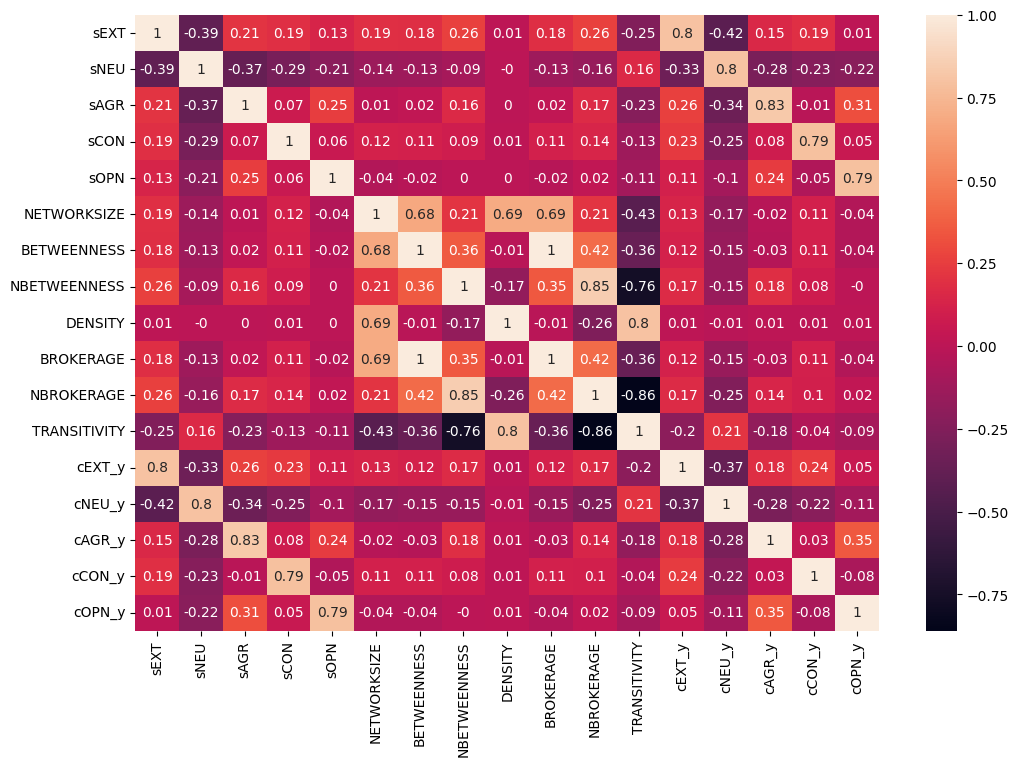

In [85]:
# We focus on the high correlation values of the score features. The person who have high score of Extroversion tends 
# not to be Neuroticism. Also, there are others feature that correlated to each other as shown in the figure.

plt.figure(figsize=(12,8))
sns.heatmap(data_dummy.corr().round(2),annot=True)

In [151]:
# Frequency of word w/o remove stopwords
cvec = CountVectorizer()
tokenied_status = cvec.fit_transform(data_dummy['STATUS'])
token_df = pd.DataFrame(tokenied_status.toarray(),columns = cvec.get_feature_names_out())
token_df.sum().sort_values(ascending=False)[:20]

the         4982
to          4477
is          3156
and         3058
of          2093
in          1984
it          1669
for         1641
my          1564
you         1495
propname    1309
that        1158
on          1094
with         956
be           894
me           816
at           796
this         760
so           726
have         722
dtype: int64

In [238]:
# Frequency of words w/ remove stopwords,  by using TFID.
tfid = TfidfVectorizer(stop_words='english')
tokenied_status = tfid.fit_transform(data_dummy['STATUS'])
token_df = pd.DataFrame(tokenied_status.toarray(),columns = tfid.get_feature_names_out())
token_df.sum().sort_values(ascending=False)[:15]

propnam    250.793605
day        154.409109
just       134.511518
thi        125.608492
work       124.739588
ha         114.781370
love       112.041007
time       107.809953
like       105.634700
wa         102.719493
new         93.609792
want        92.157210
today       90.736529
good        85.572724
need        83.651694
dtype: float64

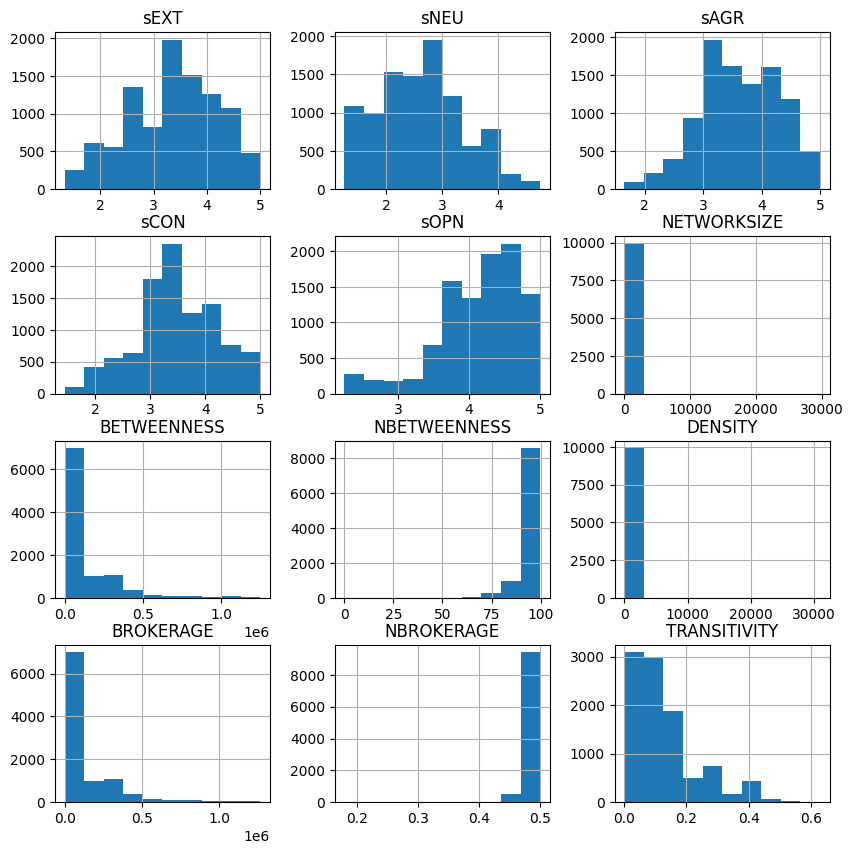

In [68]:
data.hist(figsize=(10,10));
# Most people tend not to be Neuroticism, but perfer to be more on Agreeableness and Openness


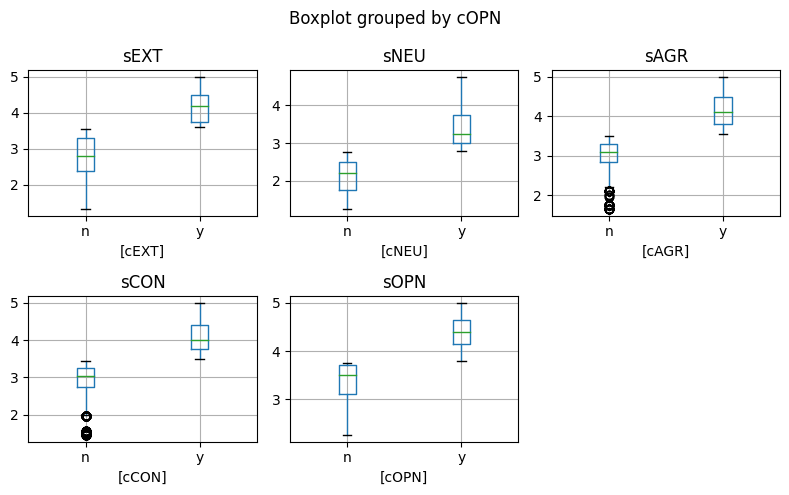

In [34]:
fig,ax = plt.subplots(2,3 ,figsize=(8,5))
plt.delaxes(ax[1][2])
data[['sEXT','cEXT']].boxplot(by='cEXT',ax = ax[0][0])
data[['sNEU','cNEU']].boxplot(by='cNEU',ax = ax[0][1])
data[['sAGR','cAGR']].boxplot(by='cAGR',ax = ax[0][2])
data[['sCON','cCON']].boxplot(by='cCON',ax = ax[1][0])
data[['sOPN','cOPN']].boxplot(by='cOPN',ax = ax[1][1]);
plt.tight_layout()

# There are significant differences of score in each group of personality trait.

**5. What is the difference between CountVectorizer and TFIDFVectorizer?**

- Countvectorizer only tokenize the text  and count the existed time of the word, or in other word its show how frequent of that word shows in the text.


- TFIDFVectorizer also do the samething, but add up with it can ranking the word automatically. By first it will take log and inverse the ratio of all documents and token, that will give the number after normalized in range of 0 - 1. The closer to zero of that token mean that it show frequently in corpus and not really important.

**6. What are stopwords?**

In [ ]:
#  The word that appear a lot in the text and not have meaning a lot to the key part of the text (context), 
# but it may help to make the sentence complete on grammar.

**7. Give an example of when you might remove stopwords.**

In [ ]:
# When there are a lot of stop word that make our model fail to predict and ambigious. 
# When there is a hugh bunch of features and we want to reduce the features to increase the computational time.

**8. Give an example of when you might keep stopwords in your model.**

In [86]:
# When the stop word is important. For example the corpus that use to predict what animal is talked about and how many are they?
# So, 'a' characters will be important now, it represent the number of 1 of that animal.

### Step 4: Model the data.

We are going to fit two types of models: a logistic regression and [a Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html).

**Reminder:** We will only use the feature `STATUS` to model `cAGR`.

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [41]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7437,), (2480,), (7437,), (2480,))

### We want to attempt to fit our models on sixteen sets of features:

1. CountVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
2. CountVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
3. CountVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
4. CountVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
5. CountVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
6. CountVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
7. CountVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
8. CountVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.
9. TFIDFVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
10. TFIDFVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
11. TFIDFVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
12. TFIDFVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
13. TFIDFVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
14. TFIDFVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
15. TFIDFVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
16. TFIDFVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.

**9. Rather than manually instantiating 16 different vectorizers, what `sklearn` class have we learned about that might make this easier? Use it.**

In [266]:
# Countvector

# parameters
cv_param = {'cvec__stop_words':[None,'english'],'cvec__ngram_range':[(1, 1),(1,2)],'cvec__max_features':[100,500]}

# pipe line NB
pipe_cv_nb = Pipeline([('cvec',CountVectorizer()),('nb',MultinomialNB())])

# pipe line logreg
pipe_cv_log = Pipeline([('cvec',CountVectorizer()),('log',LogisticRegression(penalty='none'))])
# pipe_cv_log = Pipeline([('cvec',CountVectorizer()),('ss',StandardScaler()),('log',LogisticRegression())])




#  TFID
# parameters
tfid_param = {'tfid__stop_words':[None,'english'],'tfid__ngram_range':[(1, 1),(1,2)],'tfid__max_features':[100,500]}

# pipe line NB
pipe_tfid_nb = Pipeline([('tfid',TfidfVectorizer()),('nb',MultinomialNB())])

# pipe line logreg
# pipe_tfid_log = Pipeline([('tfid',TfidfVectorizer()),('log',LogisticRegression(penalty='none'))])
pipe_tfid_log = Pipeline([('tfid',TfidfVectorizer()),('log',LogisticRegression(penalty='none'))])

**10. What are some of the advantages of fitting a logistic regression model?**

In [267]:
# Logistic regression model is the parametic model that can output the coefficient of the features can we can see the 
# important in each feature that act to the target variable.

**11. Fit a logistic regression model and compare it to the baseline.**

In [268]:
# Countv
gs_cv_log = GridSearchCV(pipe_cv_log,param_grid=cv_param,cv=5,verbose=1)
gs_cv_log.fit(X_train,y_train)
cv_log_pred = gs_cv_log.predict(X_test)


# Tfid
gs_tfid_log = GridSearchCV(pipe_tfid_log,param_grid=tfid_param,cv=5,verbose=1)
gs_tfid_log.fit(X_train,y_train)
tfid_log_pred = gs_tfid_log.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

### Summary of Naive Bayes 

Naive Bayes is a classification technique that relies on probability to classify observations.
- It's based on a probability rule called **Bayes' Theorem**... thus, "**Bayes**."
- It makes an assumption that isn't often met, so it's "**naive**."

Despite being a model that relies on a naive assumption, it often performs pretty well! (This is kind of like linear regression... we aren't always guaranteed homoscedastic errors in linear regression, but the model might still do a good job regardless.)
- [Interested in details? Read more here if you want.](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)


The [sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) is here, but it can be intimidating. So, to quickly summarize the Bayes and Naive parts of the model...

#### Bayes' Theorem
If you've seen Bayes' Theorem, it relates the probability of $P(A|B)$ to $P(B|A)$. (Don't worry; we won't be doing any probability calculations by hand! However, you may want to refresh your memory on conditional probability from our earlier lessons if you forget what a conditional probability is.)

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that someone is "agreeable," like the OCEAN category.
- Let $B$ represent the words used in their Facebook post.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{person is agreeable}|\text{words in Facebook post}) &=& \frac{P(\text{words in Facebook post}|\text{person is agreeable})P(\text{person is agreeable})}{P(\text{words in Facebook post})}
\end{eqnarray*}
$$

We want to calculate the probability that someone is agreeable **given** the words that they used in their Facebook post! (Rather than calculating this probability by hand, this is done under the hood and we can just see the results by checking `.predict_proba()`.) However, this is exactly what our model is doing. We can (a.k.a. the model can) calculate the pieces on the right-hand side of the equation to give us a probability estimate of how likely someone is to be agreeable given their Facebook post.

#### Naive Assumption

If our goal is to estimate $P(\text{person is agreeable}|\text{words in Facebook post})$, that can be quite tricky.

---

<details><summary>Bonus: if you want to understand why that's complicated, click here.</summary>
    
- The event $\text{"words in Facebook post"}$ is a complicated event to calculate.

- If a Facebook post has 100 words in it, then the event $\text{"words in Facebook post"} = \text{"word 1 is in the Facebook post" and "word 2 is in the Facebook post" and }\ldots \text{ and "word 100 is in the Facebook post"}$.

- To calculate the joint probability of all 100 words being in the Facebook post gets complicated pretty quickly. (Refer back to the probability notes on how to calculate the joint probability of two events if you want to see more.)
</details>

---

To simplify matters, we make an assumption: **we assume that all of our features are independent of one another.**

In some contexts, this assumption might be realistic!

**12. Why would this assumption not be realistic with NLP data?**

- Before becoming the features, they were grouping in a sentences and construct into a corpus. If some word that is missing from the sentence, like I want to ...., that will make the sentence no meaning. So, the assumption of independent in each features is totally wrong.

Despite this assumption not being realistic with NLP data, we still use Naive Bayes pretty frequently.
- It's a very fast modeling algorithm. (which is great especially when we have lots of features and/or lots of data!)
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - Bernoulli Naive Bayes is appropriate when our features are all 0/1 variables.
        - [Bernoulli NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
    - Multinomial Naive Bayes is appropriate when our features are variables that take on only positive integer counts.
        - [Multinomial NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
    - Gaussian Naive Bayes is appropriate when our features are Normally distributed variables. (Realistically, though, we kind of use Gaussian whenever neither Bernoulli nor Multinomial works.)
        - [Gaussian NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

**13. Suppose you CountVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

In [94]:
# Multinomialnb is appropate in this scenario because after tokenize by Countvectorizer. 
# The count value is not gonna be binary form because there could be duplicate word in each document that make
# the value not just 1 or 0.


# Countv
gs_cv_nb = GridSearchCV(pipe_cv_nb,param_grid=cv_param,cv=5,verbose= 1)
gs_cv_nb.fit(X_train,y_train)
cv_nb_pred = gs_cv_nb.predict(X_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


**14. Suppose you TFIDFVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.**

In [95]:
# Multinomialnb is appropiate in this scenario because  
# the factorial terms that got from TFID presentend as a value of each token 
# can essentially be ignored in the calculation.So, that made Multinomial simply match to the case and able to use. 


# TFid
gs_tfid_nb = GridSearchCV(pipe_tfid_nb,param_grid=tfid_param,cv=5,verbose=1)
gs_tfid_nb.fit(X_train,y_train)
tfid_nb_pred = gs_tfid_nb.predict(X_test)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


**15. Compare the performance of your models.**

- Define functions for evaluate the perfomance of model

In [110]:
def report(y_test,*argv):
    '''Show the classification report each model'''
    for i,j in enumerate(argv):
        print(f'Model{i+1} classification report \n{classification_report(y_test,j)}')
    

In [127]:
def score(X_train,X_test,y_train,y_test,*argv):
    '''Show the accuracy of each model'''
    for i,j in enumerate(argv):
        print(f'Model {i+1}')
        print(f'Train Score:{j.score(X_train,y_train)}')
        print(f'Test  Score:{j.score(X_test,y_test)}\n\n')

- call functions

In [128]:
# origin no scale
score(X_train,X_test,y_train,y_test,gs_cv_log,gs_tfid_log,gs_cv_nb,gs_tfid_nb)

Model 1
Train Score:0.6173188113486621
Test  Score:0.5467741935483871


Model 2
Train Score:0.6261933575366411
Test  Score:0.5455645161290322


Model 3
Train Score:0.608713190802743
Test  Score:0.5471774193548387


Model 4
Train Score:0.6128815382546726
Test  Score:0.5475806451612903




In [264]:
# with scale , logreg L2
score(X_train,X_test,y_train,y_test,gs_cv_log,gs_tfid_log,gs_cv_nb,gs_tfid_nb)

Model 1
Train Score:0.6193357536641119
Test  Score:0.540725806451613


Model 2
Train Score:0.628075837031061
Test  Score:0.5262096774193549


Model 3
Train Score:0.6054860830980234
Test  Score:0.5379032258064517


Model 4
Train Score:0.6066962484872933
Test  Score:0.5459677419354839




In [269]:
# with scale, logreg none
score(X_train,X_test,y_train,y_test,gs_cv_log,gs_tfid_log,gs_cv_nb,gs_tfid_nb)

Model 1
Train Score:0.6261933575366411
Test  Score:0.5286290322580646


Model 2
Train Score:0.6282102998520909
Test  Score:0.5294354838709677


Model 3
Train Score:0.6054860830980234
Test  Score:0.5379032258064517


Model 4
Train Score:0.6066962484872933
Test  Score:0.5459677419354839




In [270]:
# with scale, logreg none

report(y_test,cv_log_pred,tfid_log_pred,cv_nb_pred,tfid_nb_pred)

Model1 classification report 
              precision    recall  f1-score   support

           n       0.50      0.41      0.45      1176
           y       0.54      0.64      0.59      1304

    accuracy                           0.53      2480
   macro avg       0.52      0.52      0.52      2480
weighted avg       0.52      0.53      0.52      2480

Model2 classification report 
              precision    recall  f1-score   support

           n       0.50      0.43      0.46      1176
           y       0.55      0.62      0.58      1304

    accuracy                           0.53      2480
   macro avg       0.53      0.52      0.52      2480
weighted avg       0.53      0.53      0.53      2480

Model3 classification report 
              precision    recall  f1-score   support

           n       0.52      0.40      0.45      1176
           y       0.55      0.66      0.60      1304

    accuracy                           0.54      2480
   macro avg       0.53      0.53     

In [265]:
# logreg L2
report(y_test,cv_log_pred,tfid_log_pred,cv_nb_pred,tfid_nb_pred)

Model1 classification report 
              precision    recall  f1-score   support

           n       0.52      0.40      0.45      1176
           y       0.55      0.67      0.60      1304

    accuracy                           0.54      2480
   macro avg       0.54      0.53      0.53      2480
weighted avg       0.54      0.54      0.53      2480

Model2 classification report 
              precision    recall  f1-score   support

           n       0.50      0.43      0.46      1176
           y       0.54      0.62      0.58      1304

    accuracy                           0.53      2480
   macro avg       0.52      0.52      0.52      2480
weighted avg       0.52      0.53      0.52      2480

Model3 classification report 
              precision    recall  f1-score   support

           n       0.52      0.40      0.45      1176
           y       0.55      0.66      0.60      1304

    accuracy                           0.54      2480
   macro avg       0.53      0.53     

In [111]:
# origin no scale
report(y_test,cv_log_pred,tfid_log_pred,cv_nb_pred,tfid_nb_pred)

Model1 classification report 
              precision    recall  f1-score   support

           n       0.53      0.41      0.46      1176
           y       0.56      0.67      0.61      1304

    accuracy                           0.55      2480
   macro avg       0.54      0.54      0.54      2480
weighted avg       0.54      0.55      0.54      2480

Model2 classification report 
              precision    recall  f1-score   support

           n       0.53      0.42      0.47      1176
           y       0.56      0.66      0.60      1304

    accuracy                           0.55      2480
   macro avg       0.54      0.54      0.54      2480
weighted avg       0.54      0.55      0.54      2480

Model3 classification report 
              precision    recall  f1-score   support

           n       0.53      0.36      0.43      1176
           y       0.55      0.71      0.62      1304

    accuracy                           0.55      2480
   macro avg       0.54      0.54     

In [235]:
gs_tfid_nb.best_params_

{'tfid__max_features': 500,
 'tfid__ngram_range': (1, 2),
 'tfid__stop_words': None}

In [236]:
gs_tfid_nb.best_estimator_

Pipeline(steps=[('tfid', TfidfVectorizer(max_features=500, ngram_range=(1, 2))),
                ('nb', MultinomialNB())])

### Model 4 is the best model performance, which is using TFIDF and MultinomialNB. While all model faces the overfitted scenario. The best parameters are max_features at 500 with bigram options and no stop word removal. For this model will give us f1-score at 0.64.

### Try using stemma.

In [230]:
# Test the model with stemma
X = data_dummy['STATUS_stem']
y = data['cAGR']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [231]:

# Countv nb , log

gs_cv_nb.fit(X_train,y_train)
cv_nb_pred = gs_cv_nb.predict(X_test)

gs_cv_log.fit(X_train,y_train)
cv_log_pred = gs_cv_log.predict(X_test)




# TFid, nb, log
gs_tfid_nb.fit(X_train,y_train)
tfid_nb_pred = gs_tfid_nb.predict(X_test)

gs_tfid_log.fit(X_train,y_train)
tfid_log_pred = gs_tfid_log.predict(X_test)



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [233]:
score(X_train,X_test,y_train,y_test,gs_cv_log,gs_tfid_log,gs_cv_nb,gs_tfid_nb)

Model 1
Train Score:0.6194702164851419
Test  Score:0.535483870967742


Model 2
Train Score:0.6229662498319215
Test  Score:0.5334677419354839


Model 3
Train Score:0.6054860830980234
Test  Score:0.5379032258064517


Model 4
Train Score:0.6066962484872933
Test  Score:0.5459677419354839




In [232]:
report(y_test,cv_log_pred,tfid_log_pred,cv_nb_pred,tfid_nb_pred)

Model1 classification report 
              precision    recall  f1-score   support

           n       0.51      0.40      0.45      1176
           y       0.55      0.66      0.60      1304

    accuracy                           0.54      2480
   macro avg       0.53      0.53      0.52      2480
weighted avg       0.53      0.54      0.53      2480

Model2 classification report 
              precision    recall  f1-score   support

           n       0.51      0.40      0.45      1176
           y       0.55      0.65      0.59      1304

    accuracy                           0.53      2480
   macro avg       0.53      0.53      0.52      2480
weighted avg       0.53      0.53      0.53      2480

Model3 classification report 
              precision    recall  f1-score   support

           n       0.52      0.40      0.45      1176
           y       0.55      0.66      0.60      1304

    accuracy                           0.54      2480
   macro avg       0.53      0.53     

In [ ]:
# The use of stemma before put into model didn't help improve the performance of the model.
# It just reduce the overfitting in model 4 a little bit.

**16. Even though we didn't explore the full extent of Cambridge Analytica's modeling, based on what we did here, how effective was their approach at using Facebook data to model agreeableness?**

In [5]:
# The details of Cambridge Analytica's model:
# Gather a large amount of data from Facebook.
# Use this data to predict an individual's Big5 personality "grouping."
# Design political advertisements that would be particularly effective to that particular "grouping." 

# I think that their methodology is quite good, because the last model show that it can predict the 
# agreeableness of personcorrect by 76% of agreebleness person even the use of only one X variable. 
# Also, there is some evidence/ features that could represent the characteristic of agreeableness obviously and that
# could make their model powerful. In addition their model should add more the person that not being agreeableness to make 
# the balanced classes scenario.